In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature

In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train if filter_feature(path) ]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test if filter_feature(path) ]

paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

  0%|          | 1/547 [00:00<00:56,  9.68it/s]

* Check Unique Feature.


100%|██████████| 547/547 [00:06<00:00, 78.64it/s]


All Features have info.
  * Diff Features: 0
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.895611
[400]	valid_0's auc: 0.90662
[600]	valid_0's auc: 0.912442
[800]	valid_0's auc: 0.91486
[1000]	valid_0's auc: 0.9166
[1200]	valid_0's auc: 0.917204
[1400]	valid_0's auc: 0.917667
Early stopping, best iteration is:
[1422]	valid_0's auc: 0.917814
[  * Fold0 Validation-DT-M 2017-12: 134339] done in 211 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.925572
[400]	valid_0's auc: 0.939116
[600]	valid_0's auc: 0.944563
[800]	valid_0's auc: 0.946699
[1000]	valid_0's auc: 0.947671
[1200]	valid_0's auc: 0.947948
Early stopping, best iteration is:
[1257]	valid_0's auc: 0.948014
[  * Fold1 Validation-DT-M 2018-3: 101968] done in 191 s
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.928008
[400]	valid_0's auc: 0.94112
[600]	valid_0's auc: 0.946913
[800]	valid_0's auc: 0.949304
[1000]	va

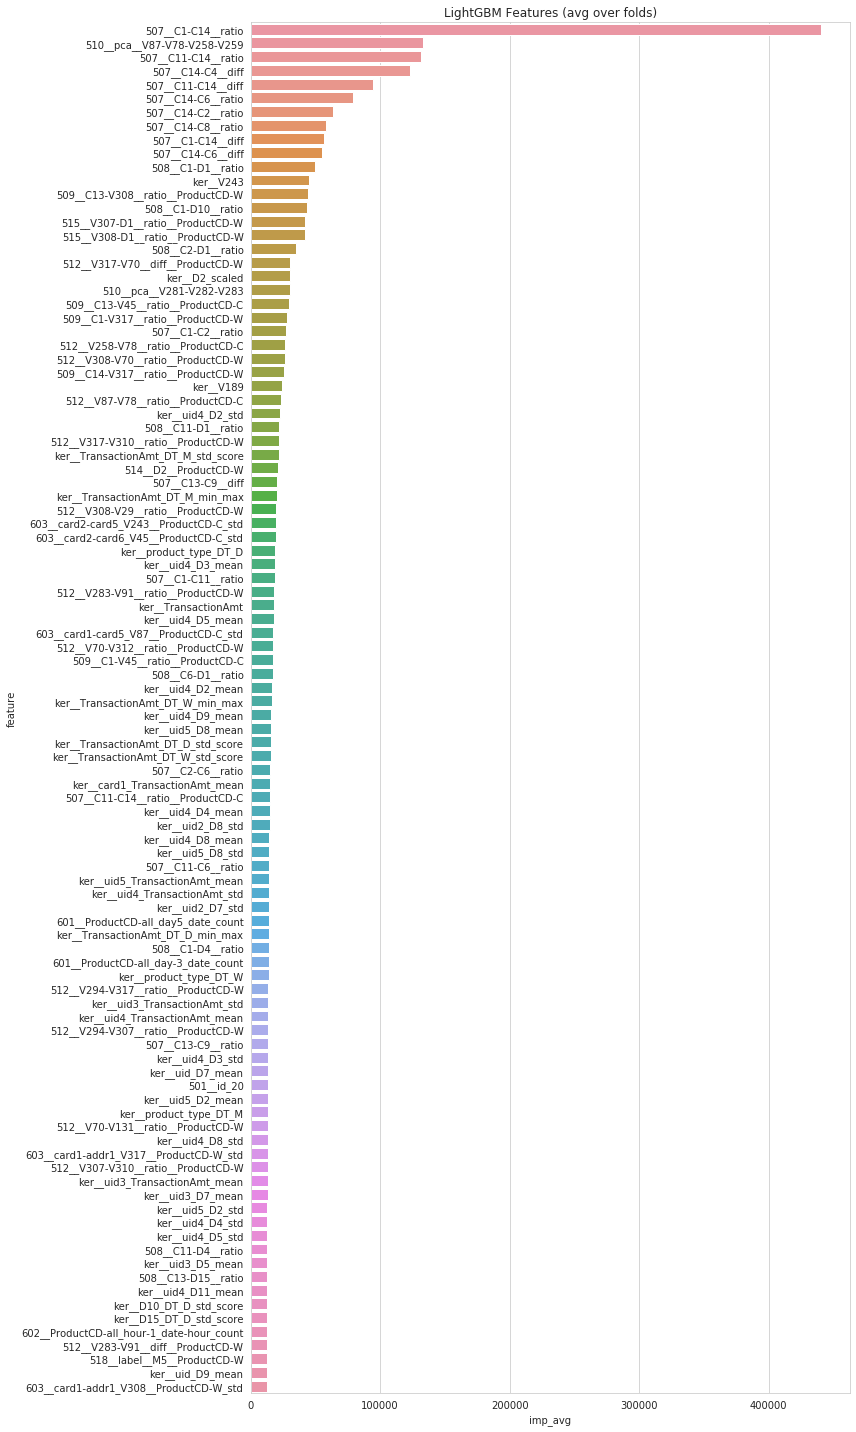

Setup Dataset dim_ml_dataset.


In [4]:
valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

df_feat_train = parallel_load_data(valid_paths_train)
df_feat_test  = parallel_load_data(valid_paths_test)

col_drops = eval_check_feature(df_feat_train, df_feat_test)

tmp_train = df_train.join(df_feat_train)
tmp_test = df_test.join(df_feat_test)

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
    'n_jobs': 64,
    'seed': 1208,
    'n_splits': 6,
    'metric': 'auc',
    'model_type': model_type,
    'objective': 'binary',
    'fold': ['stratified', 'group'][1],
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 2,
    'colsample_bytree' : 0.20,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
#     'learning_rate' : 0.1,
    'learning_rate' : 0.01,
    "early_stopping_rounds": 100,
#     "early_stopping_rounds": 50,
}
list_result_feim = eval_train(
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)

In [ ]:
pd.set_option('max_rows', 300)
feim = list_result_feim[0]
feim.head(50)
feim.tail(100)
# feim.loc[[i for i in feim.index if i.count('browser')]]

In [6]:
# submit = pd.read_csv('../submit/tmp/20190909_2324__CV0-9467296784440689__feature552.csv')
# new_submit = submit.iloc[:, 1:]
new_submit[COLUMN_ID] = new_submit[COLUMN_ID].astype('int')
new_submit.to_csv('../submit/tmp/20190909_2324__CV0-9467296784440689__feature552.csv', index=False)

In [6]:
pd.set_option('max_rows', 300)
# best_feim = read_pkl_gzip('../output/feature_importances/20190908_0913__CV0-9563060582768974__feature289.gz')
for feature_name in feim[feim['imp_avg']<600].index:
# for feature_name in best_feim.index:
#     if feature_name.count('dummie'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
#     from_dir = 'valid'
    to_dir = 'valid_trush'
#     to_dir = 'valid'
#     from_dir = 'valid_trush'
    try:
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)